# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_with_covars"
    / "gene_size_and_gene_density"
    / "gls-debug_use_ols"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_with_covars/gene_size_and_gene_density/gls-debug_use_ols/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,0.006911,0.012470,0.554245,0.579431,0.289715,random.pheno988
1,LV2,0.017586,0.012466,1.410710,0.158378,0.079189,random.pheno988
2,LV3,-0.008223,0.012520,-0.656803,0.511331,0.744335,random.pheno988
3,LV4,-0.010711,0.012569,-0.852153,0.394161,0.802920,random.pheno988
4,LV5,0.002872,0.012470,0.230323,0.817848,0.408924,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.060265450861195544

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.006,0.035,0.061
1,LV10,0.013,0.050,0.084
2,LV100,0.018,0.051,0.099
3,LV101,0.018,0.053,0.096
4,LV102,0.011,0.057,0.101


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.016596,0.060265,0.108369
std,0.007861,0.015629,0.022104
min,0.002000,0.014000,0.031000
25%,0.012000,0.050000,0.094000
50%,0.015000,0.059000,0.108000
75%,0.020000,0.069000,0.121000
max,0.101000,0.155000,0.220000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(83, 4)

,lv,1,5,10
281,LV352,0.012,0.049,0.124
285,LV356,0.014,0.049,0.101
313,LV381,0.015,0.049,0.101
708,LV737,0.014,0.049,0.093
344,LV409,0.015,0.049,0.088
345,LV41,0.013,0.049,0.075
667,LV70,0.009,0.049,0.102
348,LV412,0.009,0.049,0.102
524,LV571,0.009,0.049,0.100
355,LV419,0.011,0.049,0.096


,lv,1,5,10
934,LV940,0.012,0.051,0.088
82,LV173,0.012,0.051,0.085
171,LV253,0.014,0.051,0.101
235,LV310,0.020,0.051,0.101
214,LV292,0.011,0.051,0.091
314,LV382,0.007,0.051,0.101
676,LV708,0.012,0.051,0.115
347,LV411,0.012,0.051,0.111
624,LV661,0.010,0.051,0.112
386,LV447,0.013,0.051,0.099


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(455, 4)

,lv,1,5,10
213,LV291,0.043,0.097,0.143
631,LV668,0.028,0.097,0.154
382,LV443,0.042,0.100,0.132
28,LV124,0.036,0.100,0.150
99,LV189,0.030,0.100,0.160
663,LV697,0.035,0.100,0.161
796,LV816,0.027,0.102,0.157
142,LV227,0.043,0.103,0.147
961,LV965,0.037,0.104,0.160
471,LV523,0.033,0.105,0.174


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.004222,0.012470,0.338614,0.734912,0.367456,random.pheno988
1031,LV45,0.000438,0.012474,0.035131,0.971976,0.485988,random.pheno589
2018,LV45,-0.000854,0.012471,-0.068508,0.945383,0.527308,random.pheno385
3005,LV45,0.006603,0.012472,0.529414,0.596537,0.298268,random.pheno5
3992,LV45,-0.009837,0.012471,-0.788795,0.430261,0.784869,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.101

In [31]:
show_prop(results, 0.05)

0.155

In [32]:
show_prop(results, 0.10)

0.22

In [33]:
show_prop(results, 0.15)

0.259

In [34]:
show_prop(results, 0.20)

0.286

### QQplot

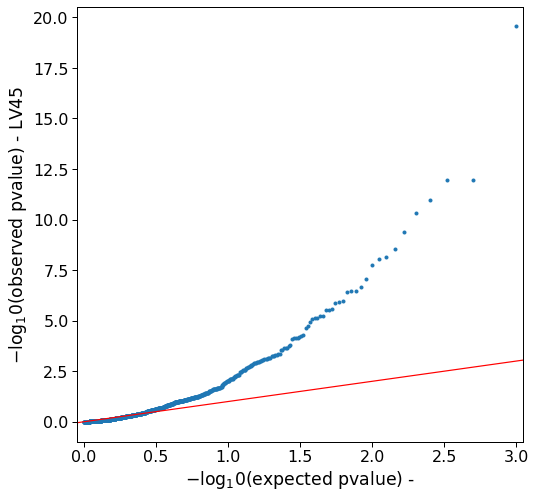

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.002127,0.012490,0.170312,0.864770,0.432385,random.pheno988
1220,LV234,-0.002014,0.012494,-0.161212,0.871931,0.564034,random.pheno589
2207,LV234,0.000846,0.012491,0.067743,0.945992,0.472996,random.pheno385
3194,LV234,0.012595,0.012492,1.008220,0.313387,0.156693,random.pheno5
4181,LV234,0.010732,0.012491,0.859229,0.390246,0.195123,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.085

In [42]:
show_prop(results, 0.05)

0.148

In [43]:
show_prop(results, 0.10)

0.2

In [44]:
show_prop(results, 0.15)

0.235

In [45]:
show_prop(results, 0.20)

0.279

### QQplot

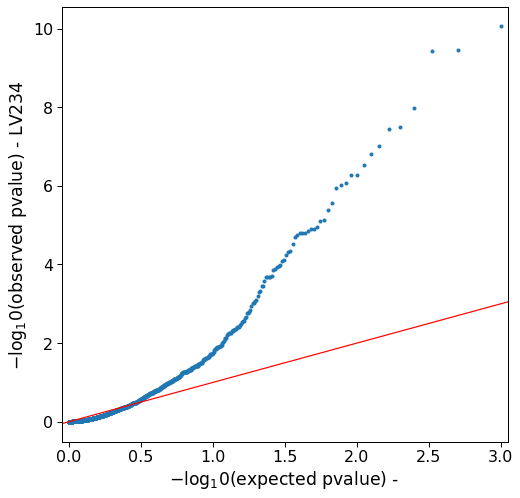

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,-0.006489,0.012489,-0.519616,0.603349,0.698325,random.pheno988
1833,LV847,0.000775,0.012493,0.062062,0.950516,0.475258,random.pheno589
2820,LV847,-0.004695,0.012490,-0.375906,0.706999,0.646500,random.pheno385
3807,LV847,0.007745,0.012492,0.620011,0.535273,0.267636,random.pheno5
4794,LV847,0.013541,0.012489,1.084228,0.278304,0.139152,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.089

In [53]:
show_prop(results, 0.05)

0.138

In [54]:
show_prop(results, 0.10)

0.187

In [55]:
show_prop(results, 0.15)

0.219

In [56]:
show_prop(results, 0.20)

0.254

### QQplot

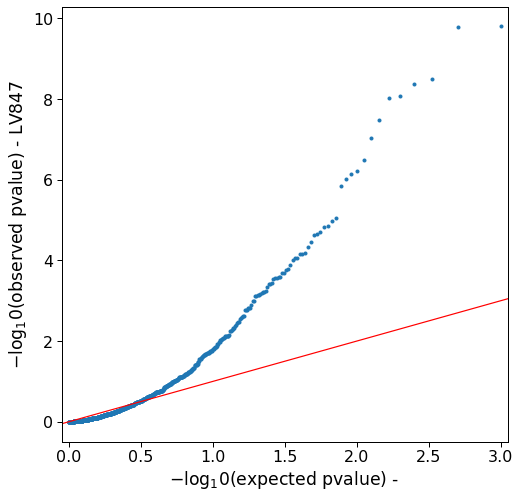

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.026692,0.012490,-2.137122,0.032626,0.983687,random.pheno988
1096,LV110,-0.000010,0.012498,-0.000817,0.999348,0.500326,random.pheno589
2083,LV110,-0.006505,0.012495,-0.520598,0.602665,0.698667,random.pheno385
3070,LV110,-0.006638,0.012497,-0.531164,0.595324,0.702338,random.pheno5
4057,LV110,0.008511,0.012495,0.681116,0.495822,0.247911,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.075

In [64]:
show_prop(results, 0.05)

0.121

In [65]:
show_prop(results, 0.10)

0.172

In [66]:
show_prop(results, 0.15)

0.208

In [67]:
show_prop(results, 0.20)

0.241

### QQplot

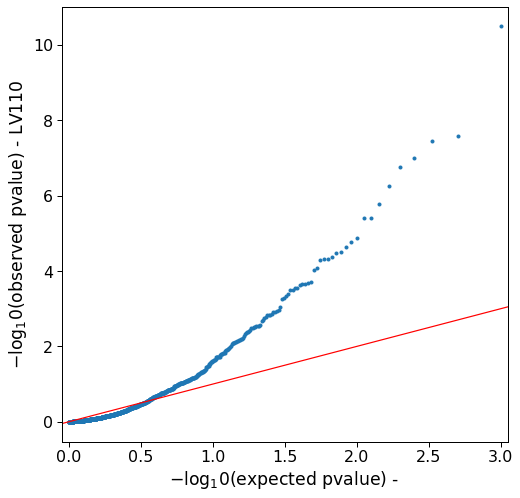

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.012602,0.012457,1.011617,0.311759,0.155880,random.pheno988
1755,LV769,0.001504,0.012463,0.120682,0.903946,0.451973,random.pheno589
2742,LV769,0.001941,0.012460,0.155807,0.876190,0.438095,random.pheno385
3729,LV769,-0.021338,0.012459,-1.712746,0.086807,0.956596,random.pheno5
4716,LV769,-0.018916,0.012458,-1.518334,0.128979,0.935510,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.037

In [75]:
show_prop(results, 0.05)

0.12

In [76]:
show_prop(results, 0.10)

0.198

In [77]:
show_prop(results, 0.15)

0.249

In [78]:
show_prop(results, 0.20)

0.305

### QQplot

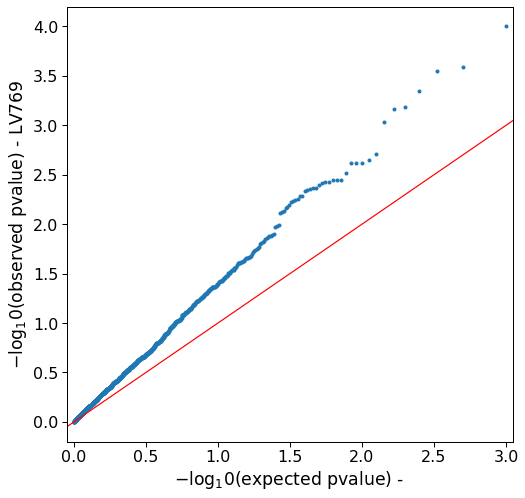

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.011918,0.012481,0.954864,0.339682,0.169841,random.pheno988
1786,LV800,0.003183,0.012486,0.254961,0.798762,0.399381,random.pheno589
2773,LV800,-0.010985,0.012483,-0.880035,0.378873,0.810564,random.pheno385
3760,LV800,-0.022650,0.012482,-1.814703,0.069616,0.965192,random.pheno5
4747,LV800,-0.008875,0.012483,-0.710918,0.477161,0.761419,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.047

In [86]:
show_prop(results, 0.05)

0.113

In [87]:
show_prop(results, 0.10)

0.179

In [88]:
show_prop(results, 0.15)

0.212

In [89]:
show_prop(results, 0.20)

0.252

### QQplot

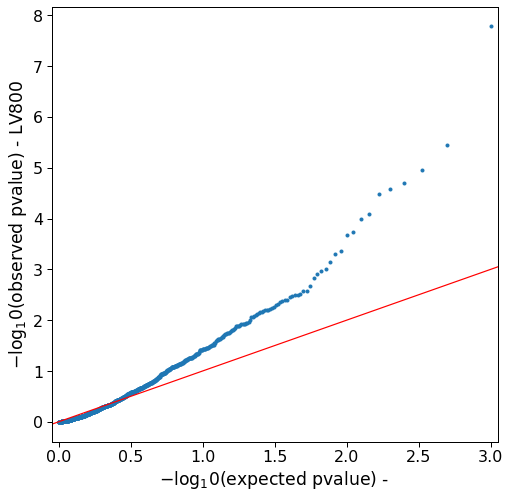

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
281,LV352,0.012,0.049,0.124
285,LV356,0.014,0.049,0.101
313,LV381,0.015,0.049,0.101
708,LV737,0.014,0.049,0.093
344,LV409,0.015,0.049,0.088
345,LV41,0.013,0.049,0.075
667,LV70,0.009,0.049,0.102
348,LV412,0.009,0.049,0.102
524,LV571,0.009,0.049,0.100
355,LV419,0.011,0.049,0.096


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,-0.009668,0.012464,-0.775656,0.437981,0.781010,random.pheno988
1398,LV412,-0.015870,0.012467,-1.272907,0.203097,0.898452,random.pheno589
2385,LV412,0.019645,0.012464,1.576197,0.115030,0.057515,random.pheno385
3372,LV412,0.009352,0.012467,0.750150,0.453192,0.226596,random.pheno5
4359,LV412,0.010336,0.012466,0.829113,0.407071,0.203536,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.009

In [99]:
show_prop(results, 0.05)

0.049

In [100]:
show_prop(results, 0.10)

0.102

In [101]:
show_prop(results, 0.15)

0.143

In [102]:
show_prop(results, 0.20)

0.182

### QQplot

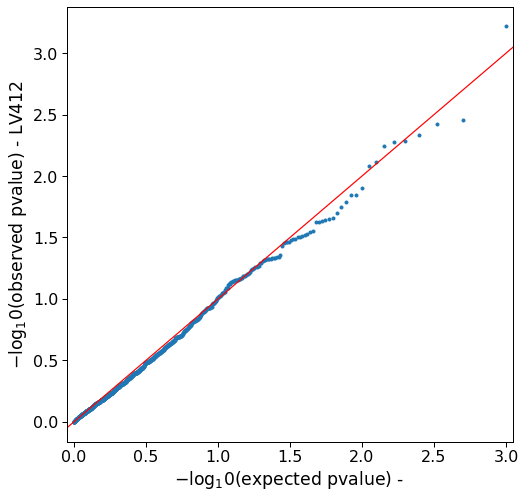

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.022281,0.012493,-1.783514,0.074550,0.962725,random.pheno988
1043,LV57,0.023651,0.012497,1.892524,0.058466,0.029233,random.pheno589
2030,LV57,0.014314,0.012496,1.145529,0.252033,0.126016,random.pheno385
3017,LV57,-0.003377,0.012499,-0.270212,0.787006,0.606497,random.pheno5
4004,LV57,0.013608,0.012496,1.088968,0.276209,0.138104,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.013

In [110]:
show_prop(results, 0.05)

0.049

In [111]:
show_prop(results, 0.10)

0.102

In [112]:
show_prop(results, 0.15)

0.139

In [113]:
show_prop(results, 0.20)

0.188

### QQplot

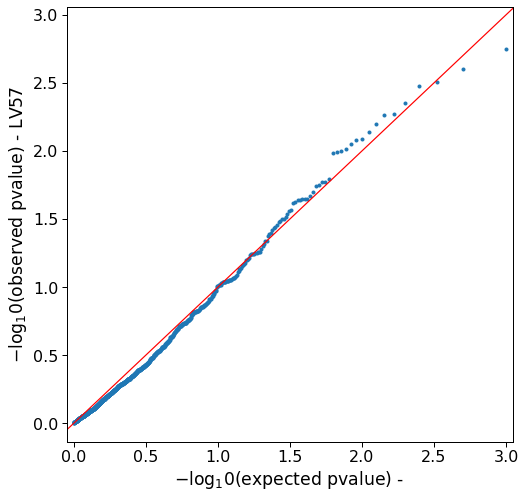

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.007293,0.012473,-0.584703,0.558768,0.720616,random.pheno988
1633,LV647,0.000525,0.012477,0.042111,0.966411,0.483206,random.pheno589
2620,LV647,0.000403,0.012475,0.032342,0.974201,0.487100,random.pheno385
3607,LV647,0.004821,0.012476,0.386440,0.699184,0.349592,random.pheno5
4594,LV647,0.004937,0.012475,0.395769,0.692289,0.346144,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.01

In [121]:
show_prop(results, 0.05)

0.051

In [122]:
show_prop(results, 0.10)

0.089

In [123]:
show_prop(results, 0.15)

0.141

In [124]:
show_prop(results, 0.20)

0.186

### QQplot

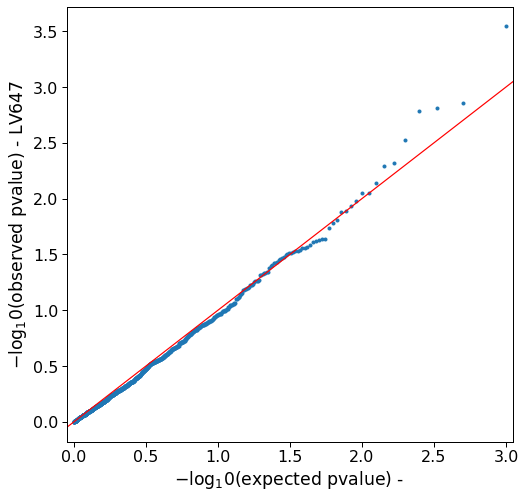

In [125]:
qqplot_unif(results)